In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from pykdf.kdf import load_kdf

In [2]:
seed = 42

par_file = "/home/ejp/src/pacological/pars/pars_test_f10.py"
save_path = "/home/ejp/src/pacological/data/test/tune"
%run ../bluemass5.py $save_path $par_file

--
0
1.65 5.0
135.0 135.0
--
1
10.325 5.0
135 135
--
0
1.65 5.0
135.0 135.0
--
1
10.325 5.0
135 135
--
0
1.65 5.0
135.0 135.0
--
1
10.325 5.0
135 135
--
0
6.3273216447 5.0
135.0 135.0
--
1
10.4779038624 5.0
135 135
--
0
5.00131554854 5.0
135.0 135.0
--
1
10.4464090259 5.0
135 135
--
0
6.88123075116 5.0
134.0 134.0
--
1
10.5433415115 5.0
135 135
--
0
7.90563489368 5.0
134.0 134.0
--
1
10.5182449935 5.0
135 135
--
0
9.1357733838 5.0
133.0 133.0
--
1
10.570841323 5.0
135 135
--
0
8.36149409559 5.0
133.0 133.0
--
1
10.5510683267 5.0
135 135
--
0
13.5734547574 5.0
131.0 131.0
--
1
10.568986982 5.0
135 135
--
0
12.1673413046 5.0
131.0 131.0
--
1
10.553625902 5.0
135 135
--
0
16.5032291582 5.0
128.0 128.0
--
1
10.5448501379 5.0
135 135
--
0
14.7591543183 5.0
128.0 128.0
--
1
10.5331281852 5.0
135 135
--
0
14.3167971763 5.0
126.0 126.0
--
1
10.5042227924 5.0
135 135
--
0
15.3550645428 5.0
126.0 126.0
--
1
10.495485786 5.0
135 135
--
0
14.7060004017 5.0
122.0 122.0
--
1
10.4518165706 5.0
135 13

In [3]:
# --
res = load_kdf(save_path + ".hdf5")
ys = res['ys']
times = res['times']
execfile(par_file)

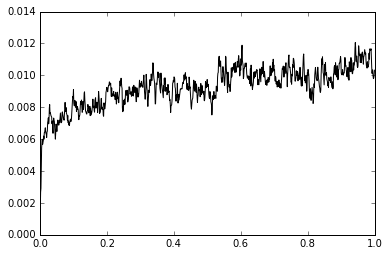

In [4]:
plt.plot(times, ys[:, res['idx_IN']], label='IN', color='k')

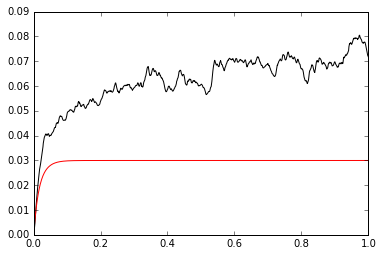

In [5]:
plt.plot(times, ys[:, res['idx_R'][0]], color='k', label='E')
plt.plot(times, ys[:, res['idx_R'][1]], color='r', label='I')

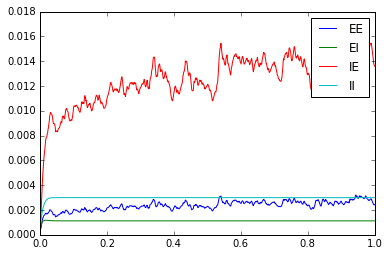

In [6]:
# plt.plot(times, ys[:, idxs['H']], label='E')
plt.plot(times, ys[:, res['idx_H'][0]], label='EE')
plt.plot(times, ys[:, res['idx_H'][1]], label='EI')
plt.plot(times, ys[:, res['idx_H'][2]], label='IE')
plt.plot(times, ys[:, res['idx_H'][3]], label='II')
plt.legend()